### [Restricted Boltzmann Machines (RBMs)](https://scikit-learn.org/stable/modules/neural_networks_unsupervised.html)

- RBMs are unsupervised *nonlinear feature learners* based on a probabilistic model. The features extracted by an RBM (or hierarchy of RBMs) can produce good results *when fed into a linear classifier* such as a linear SVM or a perceptron.

![rbm graph](px/rbm_graph.png)

- The nodes are random variables with states defined by their connection's weights and biases. An *energy function* defines the quality of a joint assignment: $E(\mathbf{v}, \mathbf{h}) = -\sum_i \sum_j w_{ij}v_ih_j - \sum_i b_iv_i
  - \sum_j c_jh_j$.
  
- "Restricted" refers to the *bipartite* model structure (direct interaction between hidden units, and between visible units, is prohibited.) This means *conditional independencies* are used: $\begin{split}h_i \bot h_j | \mathbf{v} \\
v_i \bot v_j | \mathbf{h}\end{split}$

- The bipartite structure enables using *[block Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling)* for inference.

- RBMs make assumptions about input distributions. At the moment, scikit-learn only provides BernoulliRBM (either binary or between [0..1]) values, each encoding the probability that the specific feature would be turned on.

- The conditional probability distribution of each unit is the *logistic sigmoid activation* function of its inputs: $\sigma(x) = \frac{1}{1 + e^{-x}}$

### RBM Learning

- RBMs use *Stochastic Maximum Likelihood*, "SML", or *[Persistent Contrastive Divergence](https://www.cs.toronto.edu/~tijmen/pcd/pcd.pdf), "PCD"* for training: 
$\log P(v) = \log \sum_h e^{-E(v, h)} - \log \sum_{x, y} e^{-E(x, y)}$

- The *positive* and *negative* gradient terms (the 1st & 2nd terms above) are estimated using minibatches of samples. The 1st is can be efficiently computed, but the 2nd (negative) term is intractible by direct computation. (?)

- It can be approximated by *Markov Chain Monte Carlo (MCMC)* using block Gibbs sampling, by iterating over each $h$ and $v$ until the chain "mixes". (These are sometimes referred to as "fantasy particles". This is inefficient and hard to determine whether the Markov chain mixes.

- PCD keeps a number of fantasy particles that are updated $k$ Gibbs steps after each weight update. This allows the particles to more fully explore the space.

### [Example: RBMs for digit classification](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

- Greyscale images (pixel values = degrees of blackness on a white background), 

- Artificially generate more labeled data (by perturbing the training data with linear shifts of 1 pixel in each direction) to learn *latent representations* from this small dataset.

- Build a classification pipeline with a [Bernoulli RBM](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html#sklearn.neural_network.BernoulliRBM) feature extractor and a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) classifier. The parameters (learning rate, hidden layer size, regularization) are optimized by grid search, but the search is not reproduced here because of runtime constraints.

- Logistic regression on raw pixel values is shown for comparison. The example shows the features extracted by the BernoulliRBM help improve classification accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [3]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] + [np.apply_along_axis(shift, 1, X, vector)
                              for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [4]:
X, y = datasets.load_digits(return_X_y=True)
X    = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X    = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [5]:
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.12s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.24s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.25s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.87, time = 0.24s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.23s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.09, time = 0.24s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -21.13, time = 0.25s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.58, time = 0.24s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.52, time = 0.23s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.17, time = 0.23s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

In [6]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.90      0.93      0.92       184
           2       0.93      0.95      0.94       166
           3       0.93      0.87      0.90       194
           4       0.97      0.94      0.95       186
           5       0.94      0.91      0.93       181
           6       0.98      0.97      0.98       207
           7       0.94      0.99      0.96       154
           8       0.90      0.89      0.89       182
           9       0.87      0.92      0.89       169

    accuracy                           0.93      1797
   macro avg       0.93      0.94      0.93      1797
weighted avg       0.93      0.93      0.93      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       174
           1       0.60      0.58      0.59  

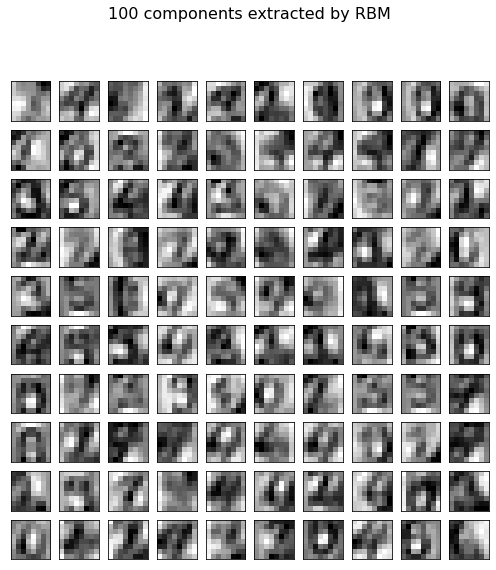

In [8]:
plt.figure(figsize=(8,8))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)